In [ ]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rectools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from implicit.nearest_neighbours import TFIDFRecommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Dataset, SparseFeatures, DenseFeatures, IdMap, Interactions
from rectools.metrics import (
    Precision,
    Recall,
    calc_metrics,
)
from rectools.models import ImplicitALSWrapperModel
from rectools.models import ImplicitItemKNNWrapperModel

**Описание датасета**

Датасет содержит информацию о пользователях lastfm (http://www.millionsongdataset.com/)

А точнее содержатся исполнители, прослушанные каждым пользователем и количество прослушиваний для каждой пары [пользователь, исполнитель].

А точнее имеет поля userID, artistID и weight.

In [33]:
ratings = pd.read_csv(
    "user_artists.dat",
    delimiter='\t',
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime]
)
ratings = ratings.drop([0])
#ratings = ratings.iloc[0:500000, 0:3]
print(ratings.shape)
ratings.head()

(92834, 4)


,user_id,item_id,weight,datetime
1,2,51,13883,NaN
2,2,52,11690,NaN
3,2,53,11351,NaN
4,2,54,10300,NaN
5,2,55,8983,NaN


In [34]:
df_train = ratings.sample(frac=0.8)
df_test = ratings.drop(df_train.index)

In [35]:
dataset = Dataset.construct(df_train)

In [36]:
def make_base_model():
    # Need to create new base model every time to use same random initializations
    return AlternatingLeastSquares(factors = 20, regularization=0.05, iterations=10)

In [37]:
als_precision = []
als_recall = []
for p in range(1,11):
  metrics = {"precision@k": Precision(p), "recall@k": Recall(p)}

  model = ImplicitALSWrapperModel(make_base_model())
  model.fit(dataset)
  recos = model.recommend(
      users=df_test[Columns.User].unique(),
      dataset=dataset,
      k = 10,
      filter_viewed = True
  )
  als_precision.append(calc_metrics(metrics, recos, df_test, df_train)['precision@k'])
  als_recall.append(calc_metrics(metrics, recos, df_test, df_train)['recall@k'])

In [38]:
knn_precision = []
knn_recall = []
for l in range(1,11):
  metrics = {"precision@k": Precision(l), "recall@k": Recall(l)}

  model2 = ImplicitItemKNNWrapperModel(TFIDFRecommender(K=10))
  model2.fit(dataset)

  # Make recommendations
  recos2 = model2.recommend(
      users=ratings[Columns.User].unique(),
      dataset=dataset,
      k = 10,
      filter_viewed=True,
  )
  knn_precision.append(calc_metrics(metrics, recos2, df_test, df_train)['precision@k'])
  knn_recall.append(calc_metrics(metrics, recos2, df_test, df_train)['recall@k'])

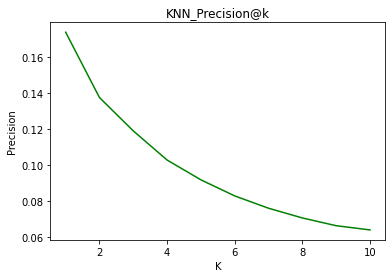

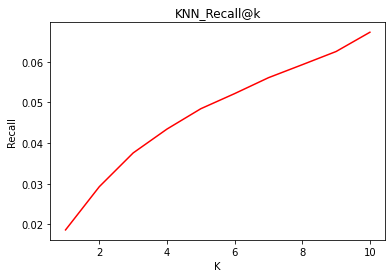

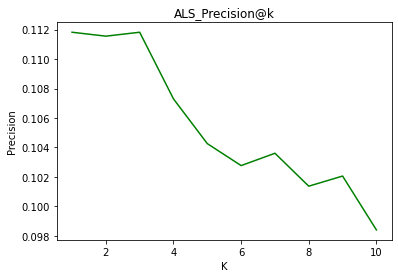

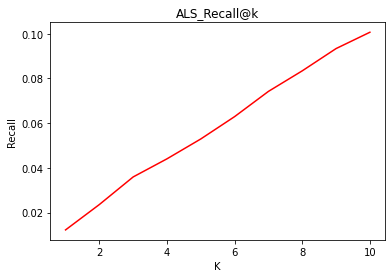

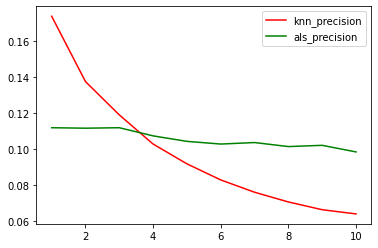

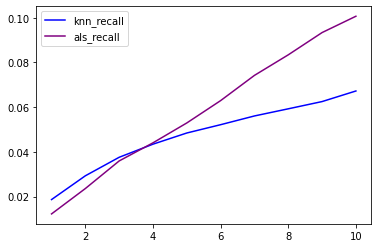

In [39]:
import matplotlib.pyplot as plt


list_k = (1,2,3,4,5,6,7,8,9,10)

fig, ax = plt.subplots()
ax.plot(list_k, knn_precision, color='green')
ax.set_title('KNN_Precision@k')
ax.set_ylabel('Precision')
ax.set_xlabel('K')
plt.show() 

fig, ay = plt.subplots()
ay.plot(list_k, knn_recall, color='red')
ay.set_title('KNN_Recall@k')
ay.set_ylabel('Recall')
ay.set_xlabel('K')
plt.show() 

fig, aw = plt.subplots()
aw.plot(list_k, als_precision, color='green')
aw.set_title('ALS_Precision@k')
aw.set_ylabel('Precision')
aw.set_xlabel('K')
plt.show() 

fig, az = plt.subplots()
az.plot(list_k, als_recall, color='red')
az.set_title('ALS_Recall@k')
az.set_ylabel('Recall')
az.set_xlabel('K')
plt.show() 

plt.plot(list_k, knn_precision, color='red', label='knn_precision')
plt.plot(list_k, als_precision, color='green', label='als_precision')
plt.legend(loc='best')
plt.show()

plt.plot(list_k, knn_recall, color='blue', label='knn_recall')
plt.plot(list_k, als_recall, color='purple', label='als_recall')
plt.legend(loc='best')
plt.show()

**Вывод**

Мы можем наглядно пронаблюдать, как с увеличением К точность работы KNN уменьшается, но при этом при маленьких К KNN лучше опредлял артистов, прослушанных пользователем. Для ALS видно, как он изначально имел не такое хорошее качество как KNN, но при этом значение K не так сильно бьет по качеству.  